# Load Library & Preprocess Data

In [27]:
import random, os, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import posenet

### Set Seed

In [28]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Hyperparameter 

In [29]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 8
mode = 'mobilenet_v1'
EPOCHS = 100

alpha = .25
gamma = 2

ckpt_path = '20200814'

In [30]:
TRAIN_ROOT_PATH = f'../../Datasets/mpii_human_pose_v1'
pd.set_option('display.max_columns', None)
df_ = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')
df_ = df_.iloc[:, 1:-3]

df_ = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]

spine = (np.array(df_.iloc[:, [15, 16]]) +  np.array(df_.iloc[:, [1, 2]])) // 2

df_ = pd.concat([df_, pd.DataFrame(spine)], axis=1)
df = df_.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                 33, 34, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]
df.rename(columns={0:'spine_X', 1:'spine_Y'}, inplace=True)

df = df.drop(df[df.iloc[:, 1] == -1].index)
df = df.drop(df[df.iloc[:, 17] == -1].index)

df.iloc[:, 0] = TRAIN_ROOT_PATH + f'/images/' + df.iloc[:, 0]
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [31]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Utils 

In [32]:
def normalize_image(image):
    mean = [0.40789655, 0.44719303, 0.47026116]
    std = [0.2886383, 0.27408165, 0.27809834]
    return ((np.float32(image) / 255.) - mean) / std

def heatmap(keypoints, input_size, output_width=32, output_height=32, sigma=1):
    
    heatmap_result = np.zeros((output_width, output_height, 17))
    offset_result = np.zeros((output_width, output_height, 34))
    displacement_fwd_result = np.zeros((output_width, output_height, 32))
    displacement_bwd_result = np.zeros((output_width, output_height, 32))
    resize_rate_w = output_width / input_size[1]
    resize_rate_h = output_height / input_size[0]
    
    def get_coords(keypoints):
        keypoints = keypoints.reshape(17, 2)
        x_radius = (np.max(keypoints[:,0]) - np.min(keypoints[:,0])) / 8
        y_radius = (np.max(keypoints[:,1]) - np.min(keypoints[:,1])) / 8
        return keypoints, x_radius, y_radius
    
    def get_heatmap(p_x, p_y, sigma):
        X1 = np.linspace(1, output_width, output_height)
        Y1 = np.linspace(1, output_width, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    def get_offset(x, y, x_radius, y_radius):
        x_radius = np.max([2, floor(x_radius * resize_rate_h)])
        y_radius = np.max([2, floor(y_radius * resize_rate_w)])
        offset_x = np.zeros((output_width, output_height))
        offset_y = np.zeros((output_width, output_height))
        p_x = floor(x * resize_rate_w)
        p_y = floor(y * resize_rate_h)
        for idx in range(output_width):
            # x - (p_x / resize_rate_w) + (1 / resize_rate_w) * (idx - p_x)
            # y - (p_y / resize_rate_h) + (1 / resize_rate_h) * (idx - p_y)
            if p_y - y_radius <= idx <= p_y + y_radius:
                offset_x[idx,p_x - x_radius:p_x + x_radius] = y - idx / resize_rate_h
            if p_x - x_radius <= idx <= p_x + x_radius:
                offset_y[p_y - y_radius:p_y + y_radius,idx] = x - idx / resize_rate_w
        return offset_x, offset_y
    
    keypoints, x_radius, y_radius = get_coords(keypoints)
    
    for idx, keypoint in enumerate(keypoints):
        if -1 in keypoint: continue
        heatmap = get_heatmap(keypoint[0] * resize_rate_w,
                              keypoint[1] * resize_rate_h,
                              sigma)
        heatmap_result[:,:,idx] = np.maximum(heatmap_result[:,:,idx], heatmap[:,:,0])
        
        offset_x, offset_y = get_offset(keypoint[0], keypoint[1], x_radius, y_radius)
        offset_result[:,:,idx] = offset_x
        offset_result[:,:,17 + idx] = offset_y
    
    return heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result

In [33]:
def draw_heatmap(batch, heatmap_result, offset_result, displacement_fwd_result=None, displacement_bwd_result=None):
        
    plt.figure(figsize=(10, 30))

    ### Heatmap
    for idx in range(17):
        plt.subplot(12,5,idx+1)
        plt.imshow(heatmap_result[batch][:,:,idx])
        plt.title(idx)

    
    ### Offset
    for idx in range(17):
        plt.subplot(12,5,idx+1+20)
        plt.imshow(offset_result[batch][:,:,idx])
        plt.colorbar()
        plt.title(idx)
        plt.subplot(12,5,idx+18+20)
        plt.imshow(offset_result[batch][:,:,17+idx])
        plt.colorbar()
        plt.title(17+idx)
        plt.show

# Datagenerator 

In [34]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, df, batch_size=4, shuffle=True,
                 random_state=42, image_paths=None, mode='fit',):
        self.list_IDs = list_IDs
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        self.mode = mode
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        list_IDs_batch = [self.list_IDs[i] for i in indexes]

        X, img_hs, img_ws = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, img_hs, img_ws)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def __generate_X(self, list_IDs_batch):
        X = []
        img_ws = []
        img_hs = []
        for i, ID in enumerate(list_IDs_batch):
            img_path = self.image_paths[ID]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.
            img_hs.append(img.shape[0])
            img_ws.append(img.shape[1])
            
            ### Show Img ###
            # plt.imshow(img)
            # plt.title(f'ID: {ID}, Shape: {img.shape}')
            ################
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
            X.append(img)
        X = np.array(X)
        return X, img_hs, img_ws
    
    def __generate_y(self, list_IDs_batch, img_hs, img_ws):
        heatmap_result = []
        offset_result = []
        displacement_fwd_result = []
        displacement_bwd_result = []
        for i, ID in enumerate(list_IDs_batch):
            keypoints = df[df.index == ID].iloc[:, 1:].to_numpy()[0]
            hm, offset, _, _ = heatmap(keypoints, input_size=(img_hs[i], img_ws[i]))
            heatmap_result.append(hm)
            offset_result.append(offset)
            # displacement_fwd_result.append(displacement_fwd)
            # displacement_bwd_result.append(displacement_bwd)
            
        heatmap_result = np.array(heatmap_result)
        offset_result = np.array(offset_result)
        # displacement_fwd_result = np.array(displacement_fwd_result)
        # displacement_bwd_result = np.array(displacement_bwd_result)
        
#         return [heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result]
        return [heatmap_result, offset_result]

# Build Model

In [9]:
with tf.device('/device:GPU:1'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile Model

### Adaptive Swing Loss 

In [10]:
def AdaptiveSwingLoss(y_pred, y_true, alpha=2.1, omega=14, epsilon=1, theta=0.5):
    lossMat = tf.zeros_like(y_pred)
    A = omega * (1/(1+(theta/epsilon)**(alpha-y_true)))*(alpha-y_true)*((theta/epsilon)**(alpha-y_true-1))/epsilon
    C = theta*A - omega*tf.math.log(1+(theta/epsilon)**(alpha-y_true))
    C = tf.cast(C, dtype=tf.float32)
    case1_ind = tf.math.abs(y_true - y_pred) < theta
    case2_ind = tf.math.abs(y_true - y_pred) >= theta
    lossMat[case1_ind] = omega*tf.math.log(1+tf.math.abs((y_true[case1_ind]-y_pred[case1_ind])/epsilon)**(alpha-y_true[case1_ind]))
    lossMat[case2_ind] = A[case2_ind]*tf.math.abs(y_true[case2_ind]-y_pred[case2_ind]) - C[case2_ind]
    # lossMat = tf.convert_to_tensor(lossMat, dtype=tf.float32)
    return lossMat.mean()

def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def criterion(y_true, y_pred): # Regression Loss

    regr_loss = mean_squared_error(y_true, y_pred)
    loss = tf.reduce_mean(regr_loss)

    return loss

def criterion2(y_true, y_pred): # Heatmap Loss
    
    loss = focal_loss(y_true, y_pred)

    return loss

### Compile 

In [11]:
model.compile(
    optimizer = optimizer,
    # loss = [tf.keras.losses.MeanAbsoluteError(),
    #        tf.keras.losses.MeanAbsoluteError()],
    # loss = [AdaptiveSwingLoss, AdaptiveSwingLoss],
    loss = [criterion2, criterion],
    loss_weights = [10, 1],
)

### Visualization 

In [12]:
bs = 4
train_gen_test = DataGenerator(
    list_IDs = train_df.index,
    df = df,
    batch_size = bs,
    shuffle = False,
    image_paths = train_df['NAME'],
    mode = 'fit',
)

img, regr = train_gen_test.__getitem__(1)
result = model(img)
# draw_heatmap(bs-1, *regr)

# Training 

In [16]:
train_gen = DataGenerator(
    list_IDs = train_df.index,
    df = df,
    batch_size = batch_size,
    shuffle = True,
    image_paths = train_df['NAME'],
    mode = 'fit',
)

val_gen = DataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = batch_size,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

ckpt = ModelCheckpoint(
    filepath = f'./checkpoints/{ckpt_path}.hdf5',
    monitor = 'loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto'
)

reducelr = ReduceLROnPlateau(
    monitor = 'loss',
    factor = .25,
    patience = 2,
    min_lr = 1e-5,
    verbose = 1,
)

In [17]:
history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    callbacks = [reducelr, ckpt],
    use_multiprocessing = False,
)

Epoch 1/100
380/380 [==============================] - 371s 977ms/step - loss: 106.0759 - mobile_net_v1_loss: 0.0057 - mobile_net_v1_1_loss: 106.0185 - val_loss: 105.5241 - val_mobile_net_v1_loss: 0.0050 - val_mobile_net_v1_1_loss: 105.4742
Epoch 2/100
380/380 [==============================] - 371s 976ms/step - loss: 96.7949 - mobile_net_v1_loss: 0.0034 - mobile_net_v1_1_loss: 96.7606 - val_loss: 99.6691 - val_mobile_net_v1_loss: 0.0032 - val_mobile_net_v1_1_loss: 99.6374
Epoch 3/100
380/380 [==============================] - 371s 977ms/step - loss: 90.2356 - mobile_net_v1_loss: 0.0030 - mobile_net_v1_1_loss: 90.2059 - val_loss: 98.7308 - val_mobile_net_v1_loss: 0.0028 - val_mobile_net_v1_1_loss: 98.7025
Epoch 4/100
380/380 [==============================] - 371s 977ms/step - loss: 84.0326 - mobile_net_v1_loss: 0.0027 - mobile_net_v1_1_loss: 84.0057 - val_loss: 98.2662 - val_mobile_net_v1_loss: 0.0027 - val_mobile_net_v1_1_loss: 98.2388
Epoch 5/100
380/380 [===========================

380/380 [==============================] - 373s 981ms/step - loss: 39.4415 - mobile_net_v1_loss: 0.0019 - mobile_net_v1_1_loss: 39.4228 - val_loss: 102.2750 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 102.2499
Epoch 36/100
380/380 [==============================] - 373s 982ms/step - loss: 39.0218 - mobile_net_v1_loss: 0.0019 - mobile_net_v1_1_loss: 39.0031 - val_loss: 103.5499 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 103.5246
Epoch 37/100
380/380 [==============================] - 372s 979ms/step - loss: 38.5737 - mobile_net_v1_loss: 0.0019 - mobile_net_v1_1_loss: 38.5551 - val_loss: 101.5627 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 101.5373
Epoch 38/100
380/380 [==============================] - 373s 982ms/step - loss: 38.0393 - mobile_net_v1_loss: 0.0019 - mobile_net_v1_1_loss: 38.0208 - val_loss: 102.9450 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 102.9198
Epoch 39/100
380/380 [==============================]

380/380 [==============================] - 373s 982ms/step - loss: 28.5889 - mobile_net_v1_loss: 0.0018 - mobile_net_v1_1_loss: 28.5714 - val_loss: 106.7010 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 106.6756
Epoch 70/100
380/380 [==============================] - 374s 983ms/step - loss: 28.4319 - mobile_net_v1_loss: 0.0018 - mobile_net_v1_1_loss: 28.4143 - val_loss: 105.7137 - val_mobile_net_v1_loss: 0.0026 - val_mobile_net_v1_1_loss: 105.6879
Epoch 71/100
380/380 [==============================] - 373s 980ms/step - loss: 28.2077 - mobile_net_v1_loss: 0.0018 - mobile_net_v1_1_loss: 28.1902 - val_loss: 104.4704 - val_mobile_net_v1_loss: 0.0026 - val_mobile_net_v1_1_loss: 104.4448
Epoch 72/100
380/380 [==============================] - 373s 981ms/step - loss: 28.0803 - mobile_net_v1_loss: 0.0018 - mobile_net_v1_1_loss: 28.0628 - val_loss: 106.4582 - val_mobile_net_v1_loss: 0.0025 - val_mobile_net_v1_1_loss: 106.4328
Epoch 73/100
380/380 [==============================]

# History 

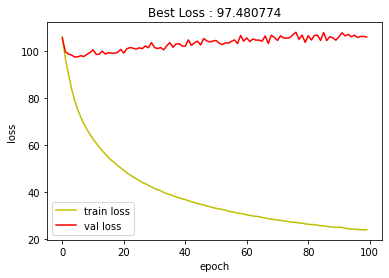

In [71]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

best = min(history.history['val_loss'])
plt.title(f'Best Loss : {best}')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='lower left')

plt.show()

# Inference 

In [35]:
ckpt_name = '20200813_alpha-25_gamma-2_batch-8.hdf5'
base_model = posenet.load_model(mode)
inputs = tf.keras.Input(shape=(256,256,3))
outputs = base_model(inputs)
inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
inf_model.load_weights(f'./checkpoints/{ckpt_name}')

In [36]:
inf_gen = DataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

In [37]:
img, regr = inf_gen.__getitem__(1)
result = inf_model(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


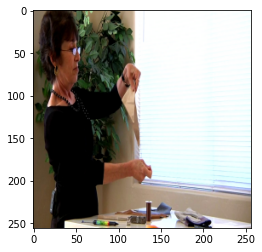

In [38]:
plt.imshow(img[0])
plt.show()

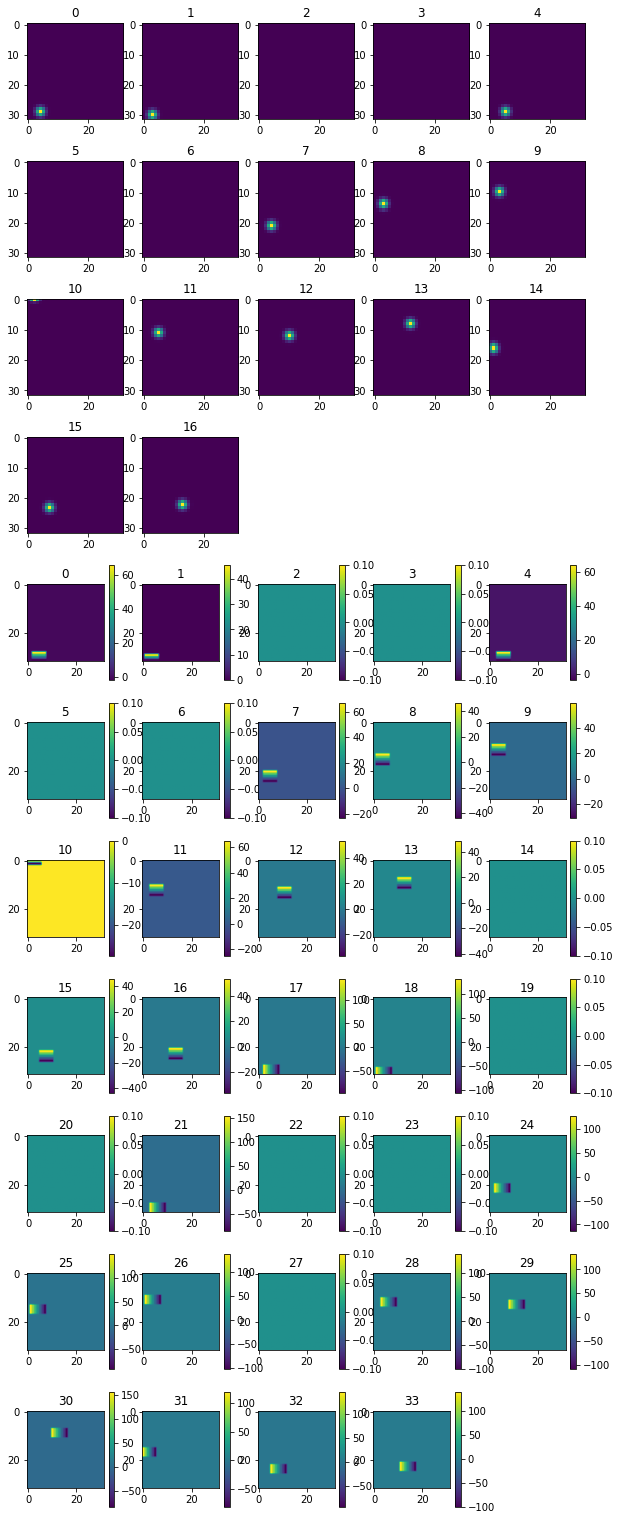

In [39]:
draw_heatmap(0, *regr)

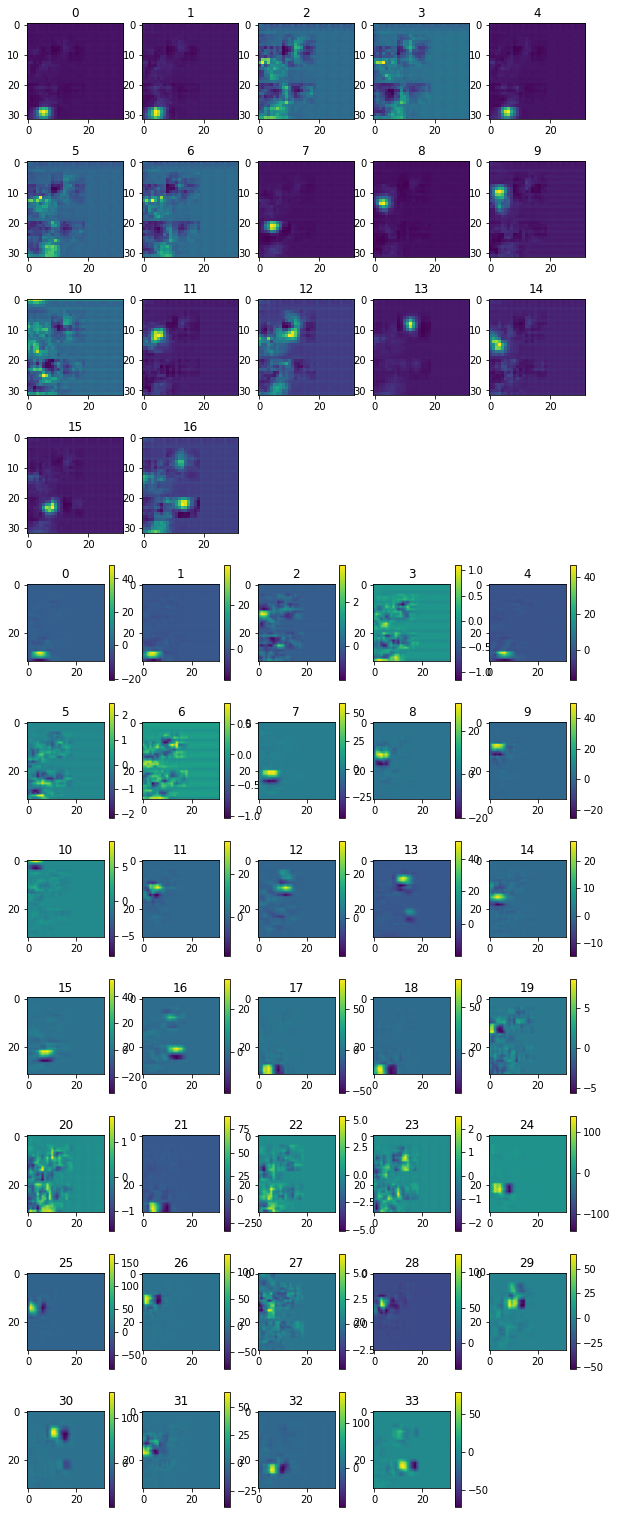

In [40]:
draw_heatmap(0, heatmap_result=result[0], offset_result=result[1])